# Two methods of K Graph Coloring Problem 2024.07.16

This notebook contains two methods of solving the graph coloring problem. Each includes QUBO matrix generated and finial color-dictionary results, also has result verification at last.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import dimod
from dwave.system import DWaveSampler, EmbeddingComposite
import time

### General and MIS related functions

In [2]:
# Function to generate and draw a graph
def generate_graph(num_nodes=3, num_edges=3, edges=None, random=False, highlight_edges=None):
    G = nx.Graph()
    if random:
        G = nx.gnm_random_graph(num_nodes, num_edges)
        edges = list(G.edges())
    else:
        if edges is None:
            raise ValueError("Edges must be provided if not generating a random graph")
        if min(min(edges)) == 1:
            edges = [(u - 1, v - 1) for u, v in edges]  # Convert 1-based to 0-based
        G.add_edges_from(edges)
        nodes = set()
        for edge in edges:
            nodes.update(edge)
        num_nodes = len(nodes)
    
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=True, node_color="grey")
    if highlight_edges:
        nx.draw_networkx_edges(G, pos, edgelist=highlight_edges, edge_color='red', width=2)
    plt.show()
    
    return G, num_nodes, edges



def gen_matrix_MIS(num_nodes, MIS_P, edges):
    matrix_MIS = np.zeros((num_nodes, num_nodes))
    np.fill_diagonal(matrix_MIS, -1)
    for edge in edges:
        i, j = edge
        matrix_MIS[i, j] = MIS_P / 2
        matrix_MIS[j, i] = MIS_P / 2
    return matrix_MIS

# Function to reencode graph after removing specified nodes
def reencode_graph_and_edges(graph, nodes_to_remove):
    new_graph = graph.copy()
    new_graph.remove_nodes_from(nodes_to_remove)
    remaining_nodes = sorted(new_graph.nodes())
    mapping = {old_label: new_label for new_label, old_label in enumerate(remaining_nodes)}
    reencoded_graph = nx.relabel_nodes(new_graph, mapping)
    updated_edges = [(mapping[u], mapping[v]) for u, v in new_graph.edges()]
    return reencoded_graph, updated_edges, mapping

# Get nodes to remove from MIS sample
def get_nodes_to_remove(node_dict):
    return {node for node, value in node_dict.items() if value == 1}

# Function to draw graph
def draw_graph(graph, title="Graph"):
    pos = nx.spring_layout(graph)
    plt.figure(figsize=(8, 6))
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title(title)
    plt.show()


In [3]:
def MIS(graph, sampler="SimulatedAnnealingSampler", QUBO_panality=2):
    print("Using: ", sampler)
    index = 0 
    total_qpu_time = 0 # sum of all qpu_access_time

    tnn = 0
    # Loop until the graph is reduced to none
    current_graph = graph
    orignal = current_graph.nodes

    nodes_to_remove_set = []
    mapping_set = []
    results_MIS_set = []

    start_t = time.time_ns() 
    if sampler == "QPU":
        qpu = DWaveSampler()
        
    while len(current_graph.nodes) != 0:
        index += 1
        nn = len(current_graph.nodes)
        edges = list(current_graph.edges)
        matrix_MIS = gen_matrix_MIS(nn, QUBO_panality, edges)

        if sampler == "ExactSolver":
            bqm_MIS = dimod.BinaryQuadraticModel.from_qubo(matrix_MIS, offset=QUBO_panality)
            solver = dimod.ExactSolver()
            results_MIS = solver.sample(bqm_MIS)
            sample_MIS = results_MIS.lowest().first.sample
            results_MIS_set.append(results_MIS)
        elif sampler == "SimulatedAnnealingSampler":    
            results_MIS = dimod.SimulatedAnnealingSampler().sample_qubo(matrix_MIS)
            sample_MIS = results_MIS.first.sample
            results_MIS_set.append(results_MIS)
        elif sampler == "QPU":
            qpu_sampler = EmbeddingComposite(qpu)
            results_MIS= qpu_sampler.sample_qubo(matrix_MIS,return_embedding=True,label=f"MIS_{len(orignal)}nodes{index}", num_reads = 500)
            total_qpu_time += results_MIS.info["timing"]['qpu_access_time']
            sample_MIS = results_MIS.lowest().first.sample
            results_MIS_set.append(results_MIS)

        nodes_to_remove = get_nodes_to_remove(sample_MIS)
        # print("MIS solution:", sample_MIS)
        nodes_to_remove_set.append(nodes_to_remove)
        print("MIS:", nodes_to_remove)

        tnn += len(nodes_to_remove)

        reencoded_graph, updated_edges, mapping = reencode_graph_and_edges(current_graph, nodes_to_remove)
        mapping_set.append(mapping)
        current_graph = reencoded_graph
        # print("Reencode graph:", mapping)
        # draw_graph(current_graph, title="Current Graph")
        # draw_graph(reencoded_graph, title="Re-encoded Graph")
    time_ms = (time.time_ns() - start_t)/1000000
    total_qpu_time = total_qpu_time/1000
   
    if tnn != len(orignal):
        print("Missing nodes in process.", tnn)
        
    print("total_qpu_time(ms):", total_qpu_time)
    print("total_time(ms):", time_ms)  
    # print("nodes_to_remove_set:", nodes_to_remove_set)
    # print("mapping_set", mapping_set)

    return total_qpu_time, time_ms, nodes_to_remove_set, mapping_set, orignal, results_MIS_set

In [4]:
def get_color_dict(color_dict, nodes_to_remove_set, mapping_set, orignal):

    def apply_mapping(current_set, depth, current_depth=0):
        x = depth - current_depth
        if current_depth == depth:
            for node in current_set:
                if node in color_dict:
                    color_dict[node] = loop
        else:
            next_set = set()
            for key, value in mapping_set[x-1].items():
                if value in current_set:
                    next_set.add(key)
            apply_mapping(next_set, depth, current_depth + 1)

    loop = 0
    for depth in range(len(nodes_to_remove_set)+1):
        loop += 1
        if depth > len(nodes_to_remove_set)-1:
            apply_mapping(mapping_set[depth-1], depth-1)
        else:
            apply_mapping(nodes_to_remove_set[depth], depth)

    k = len(set(color_dict.values()))
    print("k colors:", k)
    print("Color results:", color_dict)
    return k, color_dict

### Directly mapping graph problem into QUBO related functions

In [5]:
def node_color_to_index(node, color, k):
    index = (node) * k + (color - 1)
    return index

def create_Qmatrix(k, G, QUBO_panaliy):
    num_nodes = len(G.nodes)
    edges = list(G.edges)
    
    matrix_size = num_nodes * k
    Qmatrix = np.zeros((matrix_size, matrix_size))

    QUBO_panaliy = 4  # Penalty

    for i in range(num_nodes):
        submatrix = Qmatrix[i*k:(i+1)*k, i*k:(i+1)*k]
        for row in range(k):
            for col in range(k):
                if row == col:
                    submatrix[row, col] = -QUBO_panaliy
                else:
                    submatrix[row, col] = QUBO_panaliy
    for edge in edges:
        node1, node2 = edge
        for color in range(1, k + 1):
            index1 = node_color_to_index(node1, color, k)
            index2 = node_color_to_index(node2, color, k)
            Qmatrix[index1, index2] = QUBO_panaliy / 2
            Qmatrix[index2, index1] = QUBO_panaliy / 2

    return Qmatrix

In [6]:
def DirectlySolve(graph, k, sampler="SimulatedAnnealingSampler", QUBO_panality=4):
    print("Using: ", sampler)
    qpu_time = 0
    start_t = time.time_ns() 

    Qmatrix = create_Qmatrix(k, G, QUBO_panality)
    # print(Qmatrix)
    print("Shape of DirectlySolve Qmatrix:", Qmatrix.shape)

    if sampler == "ExactSolver":
        bqm = dimod.BinaryQuadraticModel.from_qubo(Qmatrix, offset=QUBO_panality)
        solver = dimod.ExactSolver()
        results = solver.sample(bqm)
        sample = results.lowest().first.sample
    elif sampler == "SimulatedAnnealingSampler":    
        results = dimod.SimulatedAnnealingSampler().sample_qubo(Qmatrix)
        sample = results.first.sample
    elif sampler == "QPU":
        qpu = DWaveSampler()
        qpu_sampler = EmbeddingComposite(qpu)
        results= qpu_sampler.sample_qubo(Qmatrix,return_embedding=True,label=f"DirectlySolve_{len(G.nodes)}nodes{k}colors", num_reads = 500)
        qpu_time = (results.info["timing"]['qpu_access_time'])/1000
        sample = results.lowest().first.sample

    time_ms = (time.time_ns() - start_t)/1000000
    print("Solution DirectlySolve:", sample)
    print("qpu_time_DirectlySolve(ms):", qpu_time)
    print("total_time_DirectlySolve(ms):", time_ms)

    return qpu_time, time_ms, sample, results


In [7]:
def solution_to_color_dict(solution, num_nodes, k):
    color_dict = {}
    for node in range(num_nodes):
        for color in range(k):
            if solution[node * k + color] == 1:
                color_dict[node] = color + 1
                break

    print("DirectlySolve_Color_Results:",color_dict)
    return color_dict

In [8]:
def valid_results(num_nodes, k, graph, coloring):
    if len(coloring) < num_nodes: #The node with all 0s in its corresponding qpu solution is missing in the result color dictionary, which needs to be assigned an extra color.
        print("Because of result error, one extra color will be added. k =", k+1)
        coloring = check_and_fill_missing_nodes(num_nodes, coloring, k+1)
    is_valid = validate_graph_coloring(graph, coloring)
    print("Is coloring valid? -", is_valid)
    is_minimum_coloring(graph, coloring)

def check_and_fill_missing_nodes(num_nodes, color_dict, fill_color):
    
    for key in range(num_nodes):
        if key not in color_dict:
            color_dict[key] = fill_color
            print("Error in:", key)
        
    return color_dict

def validate_graph_coloring(graph, coloring):
    for u, v in graph.edges():
        if coloring[u] == coloring[v]:
            return False  
        
        return True 


def get_approx_chromatic_number(graph):
    coloring = nx.greedy_color(graph, strategy="largest_first")
    used_colors = set(coloring.values())
    return len(used_colors)

def is_minimum_coloring(graph, coloring):
    approx_chromatic_number = get_approx_chromatic_number(graph)
    used_colors = set(coloring.values())
    if len(used_colors) == approx_chromatic_number:
        print("Is the coloring using minimum number of colors? -", True)
    else:
        print("Is the coloring using minimum number of colors? -", False)
        print("Minimum number of colors(approx_chromatic_number):", approx_chromatic_number)


# Example

## 1. Generate graph problem

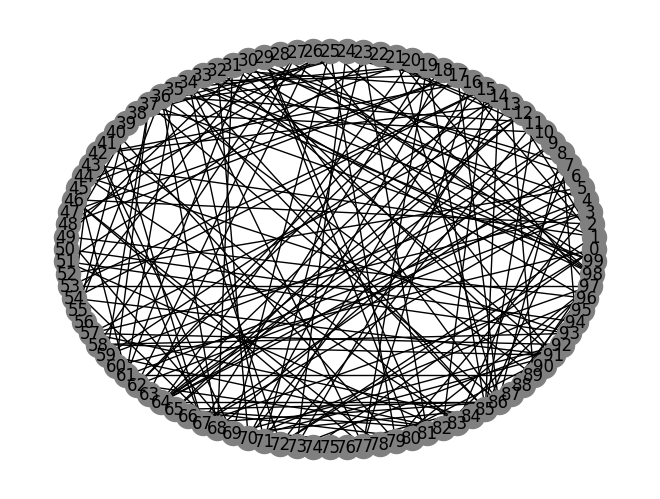

In [9]:
# Fixed Graph
# example_edges = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 1), (5, 2), (2, 4)]
# G, num_nodes, edges = generate_graph(edges=example_edges)

# Random Graph
num_nodes = 100
G, num_nodes, edges = generate_graph(num_nodes, num_nodes*2, random=True)

## 2. Using MIS method to solve the problem

In [10]:
total_qpu_time, time_ms, MIS_set, reencode_set, orignal_nodes, results_sets_MIS = MIS(G, sampler="QPU")
color_dict = {node: [] for node in orignal_nodes}
k, result = get_color_dict(color_dict, MIS_set, reencode_set, orignal_nodes)
valid_results(num_nodes, k, G, result)

Using:  QPU
MIS: {2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 18, 20, 21, 22, 24, 25, 26, 27, 28, 32, 33, 40, 43, 44, 47, 49, 50, 53, 55, 56, 60, 61, 66, 71, 72, 74, 75, 76, 77, 78, 80, 81, 82, 84, 88, 90, 92, 95, 99}
MIS: {0, 1, 2, 3, 5, 10, 11, 13, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 35, 37, 38, 39, 42, 43, 46, 47}
MIS: {0, 1, 4, 6, 7, 8, 9, 10, 13, 14, 17, 18, 19}
MIS: {0, 1, 2, 4, 5, 6}
MIS: {0}
total_qpu_time(ms): 382.71780000000007
total_time(ms): 24663.7624
k colors: 5
Color results: {0: 2, 1: 2, 2: 1, 3: 1, 4: 2, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2, 12: 1, 13: 1, 14: 1, 15: 3, 16: 2, 17: 3, 18: 1, 19: 4, 20: 1, 21: 1, 22: 1, 23: 4, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 3, 30: 2, 31: 2, 32: 1, 33: 1, 34: 4, 35: 2, 36: 3, 37: 3, 38: 2, 39: 2, 40: 1, 41: 3, 42: 3, 43: 1, 44: 1, 45: 2, 46: 2, 47: 1, 48: 2, 49: 1, 50: 1, 51: 2, 52: 2, 53: 1, 54: 2, 55: 1, 56: 1, 57: 2, 58: 2, 59: 2, 60: 1, 61: 1, 62: 2, 63: 2, 64: 2, 65: 3, 66: 1, 67: 5, 68: 4, 69: 2, 70: 3, 71:

## 3. Directly solve the problem 

In [11]:
k_preset = k
qpu_time_DirectlySolve, time_ms_DirectlySolve, solution_found, result_DS = DirectlySolve(G, k_preset, sampler="QPU")
result_DirectlySolve = solution_to_color_dict(solution_found, num_nodes, k_preset)
valid_results(num_nodes, k, G, result_DirectlySolve)

Using:  QPU
Shape of DirectlySolve Qmatrix: (500, 500)
Solution DirectlySolve: {0: 0, 1: 1, 2: 0, 3: 0, 4: 0, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 1, 14: 0, 15: 0, 16: 1, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 1, 25: 0, 26: 0, 27: 0, 28: 0, 29: 1, 30: 1, 31: 0, 32: 0, 33: 0, 34: 0, 35: 1, 36: 0, 37: 0, 38: 0, 39: 0, 40: 1, 41: 0, 42: 0, 43: 0, 44: 0, 45: 0, 46: 0, 47: 1, 48: 0, 49: 0, 50: 0, 51: 0, 52: 1, 53: 0, 54: 0, 55: 0, 56: 0, 57: 0, 58: 0, 59: 1, 60: 0, 61: 0, 62: 1, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0, 68: 1, 69: 0, 70: 0, 71: 1, 72: 0, 73: 0, 74: 0, 75: 0, 76: 0, 77: 0, 78: 0, 79: 0, 80: 0, 81: 0, 82: 0, 83: 0, 84: 1, 85: 0, 86: 1, 87: 0, 88: 0, 89: 0, 90: 0, 91: 0, 92: 0, 93: 1, 94: 0, 95: 0, 96: 1, 97: 0, 98: 0, 99: 0, 100: 0, 101: 0, 102: 0, 103: 1, 104: 0, 105: 1, 106: 0, 107: 0, 108: 0, 109: 0, 110: 0, 111: 0, 112: 0, 113: 1, 114: 0, 115: 0, 116: 0, 117: 0, 118: 0, 119: 1, 120: 0, 121: 0, 122: 0, 123: 1, 124: 0, 125: 1, 126: 0, 127: 0, 128: 0

## 4. Results comparision

In [12]:
result_DS.info

{'timing': {'qpu_sampling_time': 135950.0,
  'qpu_anneal_time_per_sample': 20.0,
  'qpu_readout_time_per_sample': 231.32,
  'qpu_access_time': 151720.76,
  'qpu_access_overhead_time': 6623.24,
  'qpu_programming_time': 15770.76,
  'qpu_delay_time_per_sample': 20.58,
  'post_processing_overhead_time': 70.0,
  'total_post_processing_time': 70.0},
 'problem_id': 'c1196719-7d9a-4840-bac8-db06b21e7146',
 'problem_label': 'DirectlySolve_100nodes5colors',
 'embedding_context': {'embedding': {1: (1989, 1988),
   0: (4645, 2063, 4495, 4646),
   2: (4556, 4555, 4557),
   3: (4420, 1973),
   4: (4616, 2019, 4540, 2139),
   6: (4383, 4384, 4382, 4381),
   5: (4758, 4757, 4756, 220, 219, 218, 217, 654),
   7: (4443, 743, 4442, 4441, 4440, 744),
   8: (729, 728, 4593, 4592, 4591, 730),
   9: (4399, 1283, 4400, 4401, 4398, 4397, 4396, 1284),
   11: (4597, 1389, 4596, 1388),
   10: (4826,
    4825,
    4824,
    4823,
    4822,
    4821,
    1315,
    1314,
    4827,
    2380,
    2379,
    2378,
    

In [13]:
embedding_qubits = result_DS.info["embedding_context"]["embedding"]
qubits = set()
for q in embedding_qubits.values():
    qubits.update(q)

# print("Qubits embedding:", embedding_qubits)
print("Qubits set:", qubits)
print("Number of qubits:", len(qubits))

Qubits set: {32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 48, 49, 50, 51, 52, 53, 54, 55, 56, 63, 64, 65, 66, 67, 68, 69, 79, 80, 81, 82, 83, 84, 85, 96, 97, 98, 99, 100, 109, 110, 111, 112, 113, 115, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 169, 170, 171, 172, 173, 174, 175, 176, 184, 185, 186, 187, 188, 189, 199, 200, 201, 202, 203, 204, 205, 206, 215, 216, 217, 218, 219, 220, 221, 228, 229, 230, 231, 232, 233, 234, 235, 236, 245, 247, 248, 249, 250, 256, 257, 258, 261, 262, 263, 264, 265, 266, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 288, 291, 292, 293, 294, 295, 305, 306, 307, 308, 309, 310, 311, 320, 322, 323, 324, 325, 333, 334, 335, 336, 337, 338, 339, 342, 343, 348, 349, 350, 351, 352, 353, 354, 355, 358, 366, 367, 368, 369, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 391, 392, 393, 394, 395, 39

In [14]:
results_sets_MIS[0].info

{'timing': {'qpu_sampling_time': 48210.0,
  'qpu_anneal_time_per_sample': 20.0,
  'qpu_readout_time_per_sample': 55.84,
  'qpu_access_time': 63969.96,
  'qpu_access_overhead_time': 1787.04,
  'qpu_programming_time': 15759.96,
  'qpu_delay_time_per_sample': 20.58,
  'post_processing_overhead_time': 1.0,
  'total_post_processing_time': 1.0},
 'problem_id': '94bfb625-54a8-4fb4-aaa9-db38a9d403ee',
 'problem_label': 'MIS_100nodes1',
 'embedding_context': {'embedding': {3: (3328,),
   1: (3312, 3313, 2266),
   12: (2280, 3026),
   11: (3147, 3148),
   13: (2356, 2357),
   17: (2372, 3432, 3343),
   20: (2490, 3088, 2491),
   15: (2011, 3162, 3161, 3163, 2012),
   19: (3087, 2250),
   21: (2325, 2326),
   23: (2431, 3268, 2430),
   10: (2596,),
   25: (3358, 3357, 2522),
   26: (3415,),
   30: (2207, 3371, 3372),
   2: (2208,),
   6: (2581, 3373),
   29: (3386, 2162),
   31: (3311, 2101),
   7: (2100,),
   32: (2102, 3431, 3430),
   33: (2026,),
   4: (2130, 3146),
   34: (3417, 2342, 2462),


In [15]:
embedding_qubits_First_MIS = results_sets_MIS[0].info["embedding_context"]["embedding"]
qubits_First_MIS = set()
for q in embedding_qubits_First_MIS.values():
    qubits_First_MIS.update(q)

# print("Qubits embedding of first MIS:", embedding_qubits)
print("Qubits set of first MIS:", qubits_First_MIS)
print("Number of qubits of first MIS:", len(qubits_First_MIS))

Qubits set of first MIS: {3072, 3086, 3087, 3088, 2581, 2070, 2071, 2072, 3101, 3102, 3103, 2596, 2086, 3116, 3117, 2100, 2101, 2102, 3131, 3132, 3133, 2115, 2116, 2117, 3146, 3147, 3148, 2130, 2131, 3161, 3162, 3163, 2145, 2146, 2147, 3177, 3178, 2161, 2162, 3190, 3191, 3192, 2176, 2177, 3206, 3207, 2191, 2192, 3220, 3221, 3222, 3223, 2205, 2206, 2207, 2208, 3236, 3237, 2220, 3251, 3252, 3253, 2235, 2236, 3266, 3267, 3268, 2250, 2251, 3281, 3282, 3283, 2265, 2266, 3295, 3296, 3297, 3298, 2280, 2281, 2282, 3310, 3311, 3312, 3313, 2295, 2296, 2297, 3326, 3327, 3328, 2310, 2311, 2312, 3341, 3342, 3343, 2325, 2326, 2327, 3355, 3356, 3357, 3358, 2340, 2341, 2342, 3371, 3372, 3373, 2355, 2356, 2357, 3386, 3387, 2370, 2371, 2372, 3400, 3401, 3402, 2386, 2387, 3415, 3416, 3417, 2400, 2401, 2402, 3430, 3431, 3432, 2415, 2416, 2417, 3445, 3446, 3447, 2430, 2431, 3461, 2445, 2446, 3476, 3477, 2460, 2461, 2462, 3490, 2981, 2982, 2983, 2475, 2476, 1965, 1966, 1967, 2997, 2490, 2491, 1981, 3011, 30

In [16]:
results_sets_MIS[1].info

{'timing': {'qpu_sampling_time': 75680.0,
  'qpu_anneal_time_per_sample': 20.0,
  'qpu_readout_time_per_sample': 110.78,
  'qpu_access_time': 91436.76,
  'qpu_access_overhead_time': 1029.24,
  'qpu_programming_time': 15756.76,
  'qpu_delay_time_per_sample': 20.58,
  'post_processing_overhead_time': 38.0,
  'total_post_processing_time': 38.0},
 'problem_id': 'db0282f5-a311-44b4-9a7d-b4edfa1ec138',
 'problem_label': 'MIS_100nodes2',
 'embedding_context': {'embedding': {6: (4325,),
   1: (4340,),
   8: (4265,),
   3: (1057,),
   4: (1207,),
   10: (1133,),
   9: (4445,),
   11: (1192, 4401),
   12: (1072,),
   13: (1118,),
   7: (4370,),
   14: (4385,),
   15: (1146, 1147),
   16: (4264,),
   18: (4505,),
   19: (1041,),
   5: (4160,),
   21: (4504,),
   22: (997,),
   25: (1208,),
   28: (4236,),
   29: (1117,),
   31: (4280,),
   32: (1102, 4235),
   33: (1027, 1026),
   2: (4205,),
   34: (4400,),
   35: (1042,),
   37: (4399,),
   39: (1148,),
   40: (4355,),
   41: (1132, 4190),
   4

In [17]:
embedding_qubits_First_MIS = results_sets_MIS[1].info["embedding_context"]["embedding"]
qubits_First_MIS = set()
for q in embedding_qubits_First_MIS.values():
    qubits_First_MIS.update(q)

# print("Qubits embedding of first MIS:", embedding_qubits)
print("Qubits set of first MIS:", qubits_First_MIS)
print("Number of qubits of first MIS:", len(qubits_First_MIS))

Qubits set of first MIS: {1026, 1027, 4355, 1923, 764, 4235, 4236, 1041, 4370, 1042, 5397, 4504, 4505, 1057, 4385, 1192, 4265, 4264, 4523, 553, 4654, 4399, 1072, 4401, 4400, 1073, 1207, 1208, 4280, 952, 1343, 4160, 4294, 4295, 1102, 5075, 4565, 4310, 4311, 4445, 1118, 1117, 4190, 4325, 997, 4582, 1132, 1133, 4205, 4475, 4340, 1012, 4476, 1146, 1147, 1148}
Number of qubits of first MIS: 56
